In [2]:
import time
import pandas as pd
from utils.hdr_utils import hdr_yuv_read
from utils.csf_utils import blockwise_csf,windows_csf
from joblib import Parallel,delayed
import numpy as np
import cv2
import queue
import glob
from colour.models import eotf_PQ_BT2100
import os
import time
import scipy.ndimage
import joblib
from scipy.stats import gmean
import sys
import matplotlib.pyplot as plt
import ChipQA.niqe 
import ChipQA.save_stats
from numba import jit,prange
import argparse
from scipy.stats import kurtosis
from skimage.util.shape import view_as_blocks
C=1
def gen_gauss_window(lw, sigma):
    sd = np.float32(sigma)
    lw = int(lw)
    weights = [0.0] * (2 * lw + 1)
    weights[lw] = 1.0
    sum = 1.0
    sd *= sd
    for ii in range(1, lw + 1):
        tmp = np.exp(-0.5 * np.float32(ii * ii) / sd)
        weights[lw + ii] = tmp
        weights[lw - ii] = tmp
        sum += 2.0 * tmp
    for ii in range(2 * lw + 1):
        weights[ii] /= sum
    return weights
def compute_image_mscn_transform(image, C=1, avg_window=None, extend_mode='constant'):
    if avg_window is None:
      avg_window = gen_gauss_window(3, 7.0/6.0)
    assert len(np.shape(image)) == 2
    h, w = np.shape(image)
    mu_image = np.zeros((h, w), dtype=np.float32)
    var_image = np.zeros((h, w), dtype=np.float32)
    image = np.array(image).astype('float32')
    scipy.ndimage.correlate1d(image, avg_window, 0, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(mu_image, avg_window, 1, mu_image, mode=extend_mode)
    scipy.ndimage.correlate1d(image**2, avg_window, 0, var_image, mode=extend_mode)
    scipy.ndimage.correlate1d(var_image, avg_window, 1, var_image, mode=extend_mode)
    var_image = np.sqrt(np.abs(var_image - mu_image**2))
    return (image - mu_image)/(var_image + C), var_image, mu_image

def spatiotemporal_mscn(img_buffer,avg_window,extend_mode='mirror'):
    st_mean = np.zeros((img_buffer.shape))
    scipy.ndimage.correlate1d(img_buffer, avg_window, 0, st_mean, mode=extend_mode)
    return st_mean

def block_compute_lnl(block,a,lnl_transform='exp_inv'):
    block = block.astype(np.float32)
    avg_luminance = np.average(block.flatten()+1)
    if(lnl_transform=='sigmoid'):
        block_transform =  1/(1+np.exp(-a*(block-avg_luminance)))
    elif(lnl_transform=='nakarushton'):
        block_transform = block/(block+avg_luminance)
    elif(lnl_transform=='exp_inv'):
        block_transform = 1/np.exp(-a*np.abs(block-avg_luminance))
    elif(lnl_transform=='logit'):
        print(np.amax(block))

        block = -0.99+(block-np.amin(block))* 1.98/(np.amax(block)-np.amin(block))
        print(np.amax(block))

        block_transform = np.log((1+(block)**a)/(1-(block)**a))
        print(np.amax(block_transform))
        print(np.amin(block_transform))
    return block_transform

    return block_transform
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array should look like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisble by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisble by {}".format(w, ncols)
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))

def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

def spatial_mscn(i,filenames,framenum,hs,ws,use_csf=True,linear=True):
    filename = filenames[i]
    name = os.path.basename(filename)
    print(name) 
    framenos = framenos_list[i]



    # SIZE of frames
    h,w = hs[i],ws[i]
    print(h,w)
    if(h>w):
        h_temp = h
        h=w
        w = h_temp
        
    # SIZE of windows
    h_win,w_win = 45,45
    max_h,max_w = int((h//h_win)*h_win),int((w//w_win)*w_win)
    #percent by which the image is resized
    scale_percent = 0.5
    # dsize
    dsize = (int(scale_percent*h),int(scale_percent*w))

    # opening file object
    dis_file_object = open(filename)
    prevY_pq,_,_ = hdr_yuv_read(dis_file_object,framenum,h,w)
    count=1
    prevY_pq = prevY_pq.astype(np.float32)
    if(linear==True):
        y_pq_normalized = prevY_pq.astype(np.float32)/1024.0
        prevY_pq = eotf_PQ_BT2100(y_pq_normalized)
    Y = prevY_pq
#     Y_mscn,_,_ = compute_image_mscn_transform(prevY_pq)

#     h_indices = np.arange(h_win//2,Y_mscn.shape[0],h_win)
#     w_indices = np.arange(w_win//2,Y_mscn.shape[1],w_win)
#     xx,yy = np.meshgrid(h_indices,w_indices)
#     print(xx,yy)
#     xx = xx.flatten()
#     yy = yy.flatten()
    xx, yy = np.mgrid[h_win//2:h-h_win//2:h_win, w_win//2:w-w_win//2:w_win].reshape(2,-1).astype(int)

    
#     blocks = blockshaped(prevY_pq[:max_h,:max_w],h_win,w_win)
#     Y = unblockshaped(blocks,max_h,max_w)
    Y_mscn,_,_ = compute_image_mscn_transform(Y)
    lnl_mscn_list =[]
    lnl_list = []
    
    for a in [1,3,5]:
#         block_lnl = Parallel(n_jobs=20,verbose=10)(delayed(block_compute_lnl)(block,a,lnl_transform='sigmoid')\
#                                                              for block in blocks) 
        #Y_lnl = unblockshaped(np.asarray(block_lnl),max_h,max_w)
        Y_lnl = block_compute_lnl(Y,a,lnl_transform='logit')
        Y_lnl_mscn,_,_ = compute_image_mscn_transform(Y_lnl,C=1e-3)
        
        lnl_list.append(Y_lnl)
        lnl_mscn_list.append(Y_lnl_mscn)
    return Y, Y_mscn,lnl_list,lnl_mscn_list


    step = st_time_length
    cy, cx = np.mgrid[step:h-step*4:step*4, step:w-step*4:step*4].reshape(2,-1).astype(int) # these will be the centers of each block
    dcy, dcx = np.mgrid[step:dsize[0]-step*4:step*4, step:dsize[1]-step*4:step*4].reshape(2,-1).astype(int) # these will be the centers of each block

    
    prevY_pq_down = cv2.resize(prevY_pq,(dsize[1],dsize[0]),interpolation=cv2.INTER_CUBIC)

    img_buffer = np.zeros((st_time_length,prevY_pq.shape[0],prevY_pq.shape[1]))
    grad_img_buffer = np.zeros((st_time_length,prevY_pq.shape[0],prevY_pq.shape[1]))
    down_img_buffer =np.zeros((st_time_length,prevY_pq_down.shape[0],prevY_pq_down.shape[1]))
    graddown_img_buffer =np.zeros((st_time_length,prevY_pq_down.shape[0],prevY_pq_down.shape[1]))


    gradient_x = cv2.Sobel(prevY_pq,ddepth=-1,dx=1,dy=0)
    gradient_y = cv2.Sobel(prevY_pq,ddepth=-1,dx=0,dy=1)
    gradient_mag = np.sqrt(gradient_x**2+gradient_y**2)    

    
    gradient_x_down = cv2.Sobel(prevY_pq_down,ddepth=-1,dx=1,dy=0)
    gradient_y_down = cv2.Sobel(prevY_pq_down,ddepth=-1,dx=0,dy=1)
    gradient_mag_down = np.sqrt(gradient_x_down**2+gradient_y_down**2)    
    i = 0


        
    
    dY_mscn,_,_ = compute_image_mscn_transform(prevY_pq_down)
    gradY_mscn,_,_ = compute_image_mscn_transform(gradient_mag)
    dgradY_mscn,_,_ = compute_image_mscn_transform(gradient_mag_down)


    return





In [3]:
input_folder = '/media/josh/hdr/fall2021_hdr_yuv'
csv_file = './fall2021_yuv_rw_info.csv'
csv_df = pd.read_csv(csv_file)
files = [os.path.join(input_folder,f) for f in csv_df["yuv"]]
for i,f in enumerate(files):
    print(i,f)
fps = csv_df["fps"]
framenos_list = csv_df["framenos"]
ws =csv_df["w"]
hs = csv_df["h"]
flag = 0
#    Parallel(n_jobs=5)(delayed(sts_fromfilename)(i,files,framenos_list,args.results_folder,use_csf=False) for i in range(len(files)))
Y,Y_mscn,Y_lnl_list,Y_lnl_mscn_list = spatial_mscn(188,files,10,hs,ws,linear=False)







0 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Bonfire.yuv
1 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CargoBoat.yuv
2 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CenterPanorama.yuv
3 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing1.yuv
4 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing3.yuv
5 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Chasing4.yuv
6 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_CourtYard.yuv
7 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Daylight1.yuv
8 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_firework.yuv
9 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_Flowers.yuv
10 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football10.yuv
11 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football1.yuv
12 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football2.yuv
13 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football3.yuv
14 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football4.yuv
15 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football5.yuv
16 /media/josh/hdr/fall2021_hdr_yuv/1080p_1M_football6.yuv
17 /media

729.0
0.99
5.29331
-5.29331
729.0
0.99
4.19476
-4.19476
729.0
0.99
3.68407
-3.68407


# Reference MSCNs

<IPython.core.display.Javascript object>


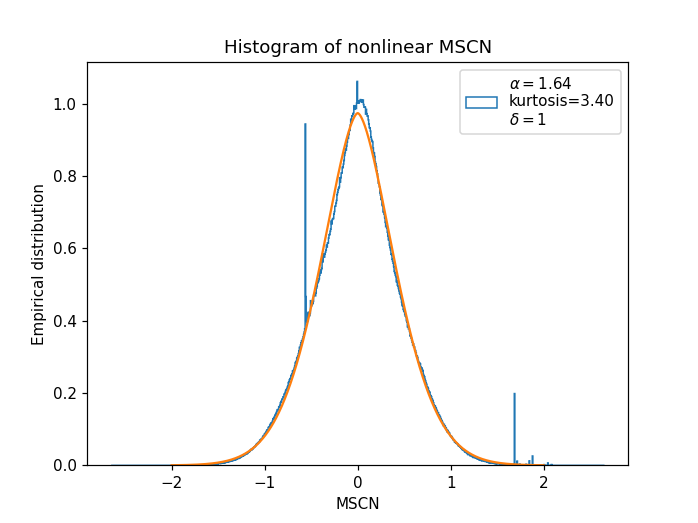

<IPython.core.display.Javascript object>


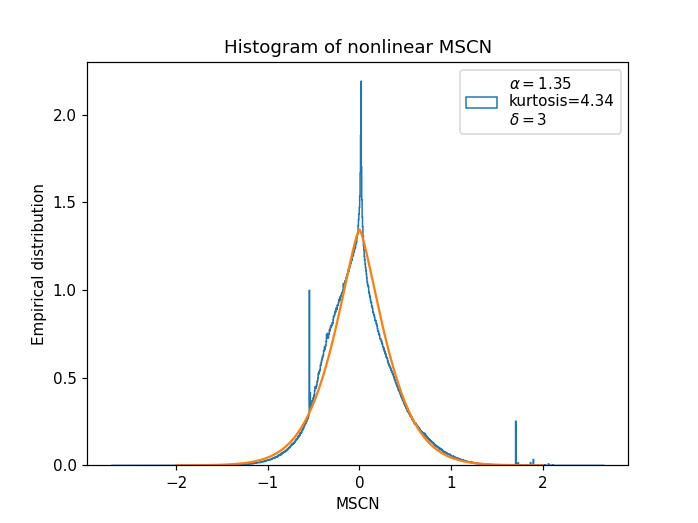

<IPython.core.display.Javascript object>


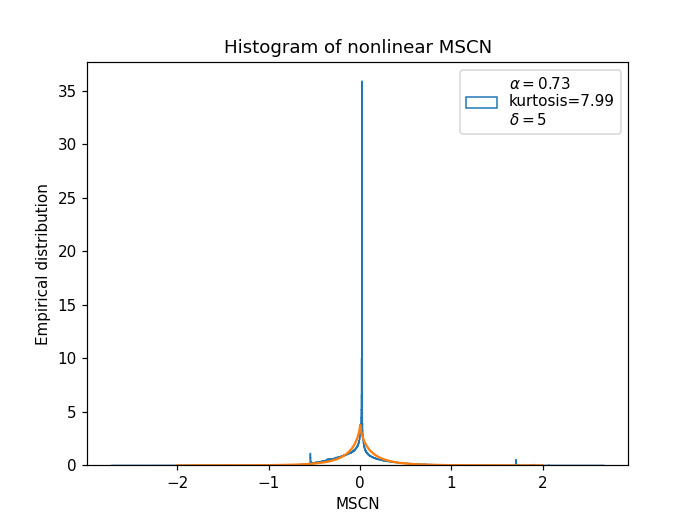

<IPython.core.display.Javascript object>


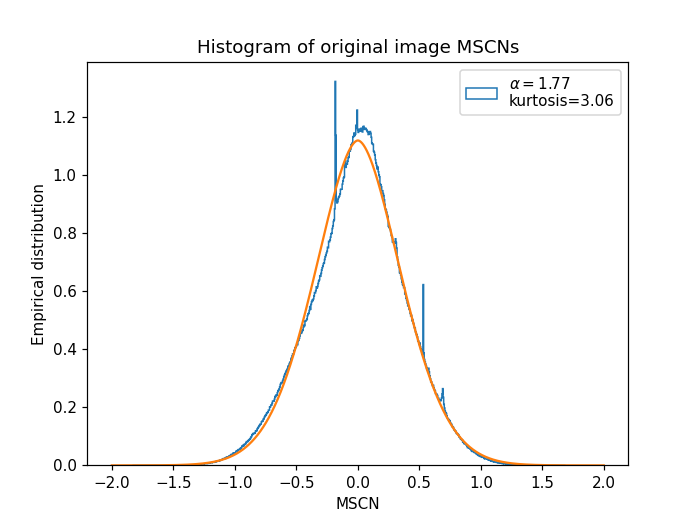

<IPython.core.display.Javascript object>


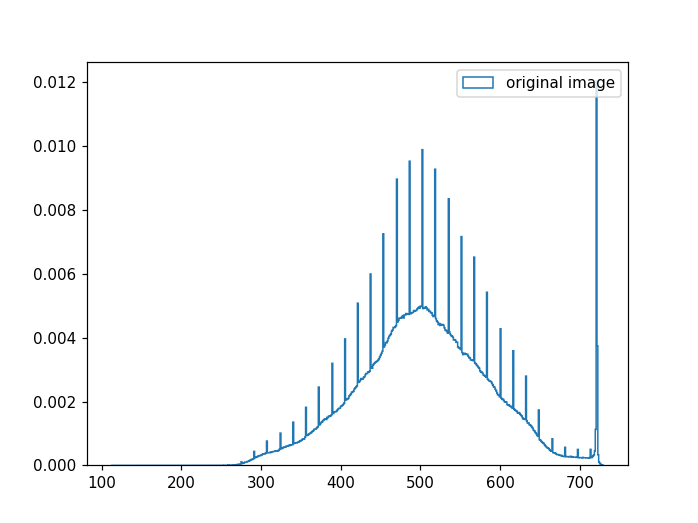

In [5]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Yplot = np.concatenate(Y_lnl_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    Y_lnl = Y_lnl_list[index]
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
plt.legend()

# Reference second order stats

(20,)


<IPython.core.display.Javascript object>


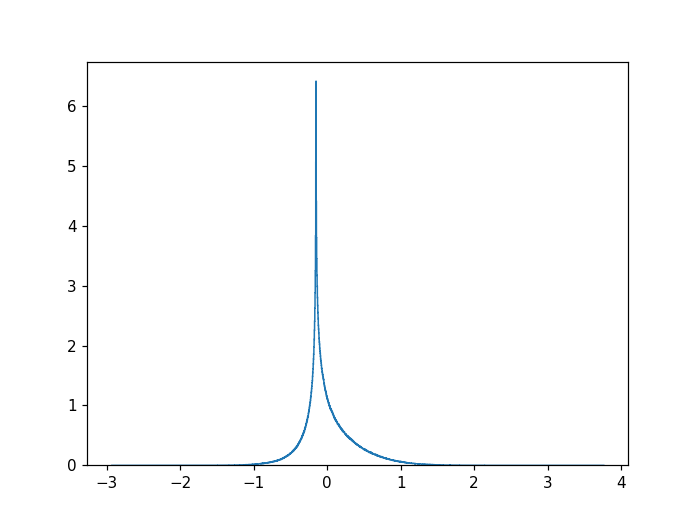

NameError: name 'x' is not defined

In [6]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

def get_aggd(aggd_feats):
    alpha = aggd_feats[0]
    sigma_l  = np.sqrt(aggd_feats[1])
    sigma_r  = np.sqrt(aggd_feats[2])
    x1 = np.arange(-2,0,0.001)
    x2 = np.arange(0,2,0.001)
    Y_aggd = ChipQA.save_stats.generate_aggd(x1,x2,alpha,sigma_l,sigma_r)
    return Y_aggd

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    pps1, pps2, pps3, pps4 = ChipQA.save_stats.paired_product(Y_lnl_mscn)
    aggd_features = ChipQA.save_stats.all_aggd(Y_lnl_mscn)
    print(aggd_features.shape)
    first_order = aggd_features[0:4]
    H_feats = aggd_features[4:8]
    V_feats = aggd_features[8:12]
    D1_feats = aggd_features[12:16]
    D2_feats = aggd_features[16:20]

    H_aggd = get_aggd(H_feats)
    V_aggd = get_aggd(V_feats)
    D1_aggd = get_aggd(D1_feats)
    D2_aggd = get_aggd(D2_feats)

    Y_lnl = Y_lnl_list[index]
    x = np.arange(-2,2,0.001)
    
    Yplot = pps1.flatten()
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(H_feats[0])[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,H_aggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear Horizontal MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of original image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'original image',density=True)
plt.legend()

## Reference LNL images

<IPython.core.display.Javascript object>


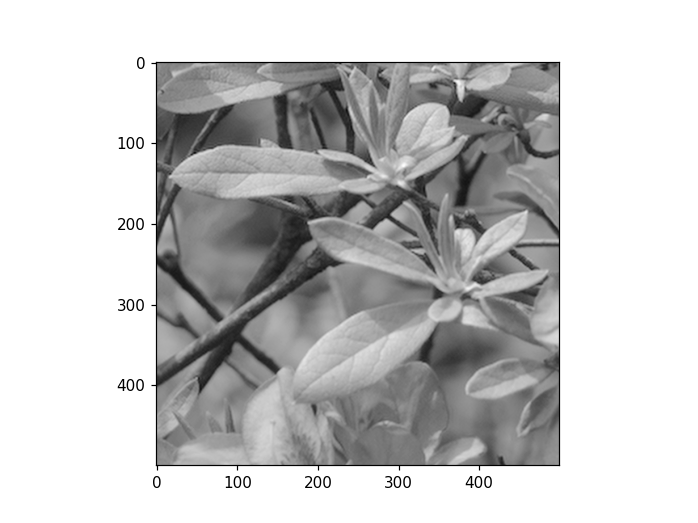

0.270933
(2160, 3840)


<IPython.core.display.Javascript object>


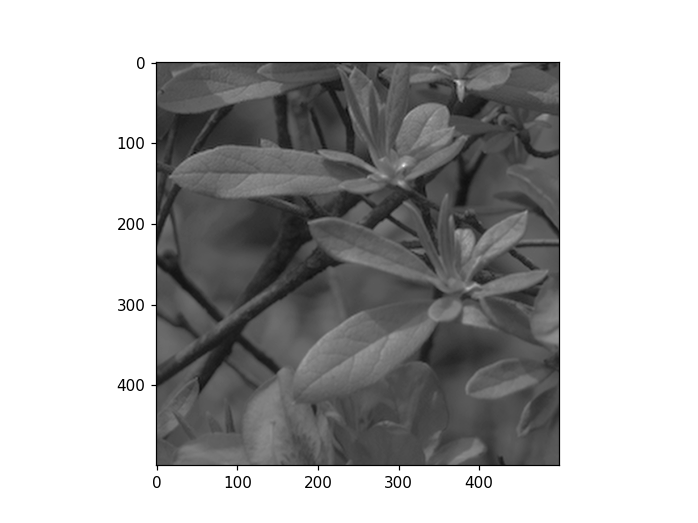

-5.29331
(2160, 3840)


<IPython.core.display.Javascript object>


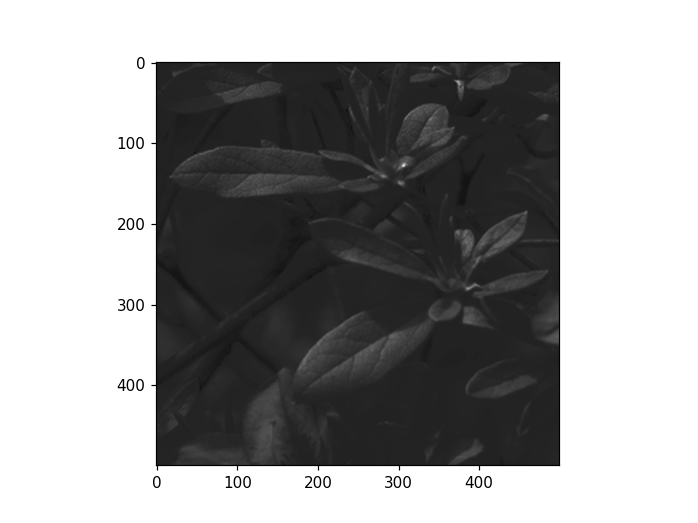

-4.19476
(2160, 3840)


<IPython.core.display.Javascript object>


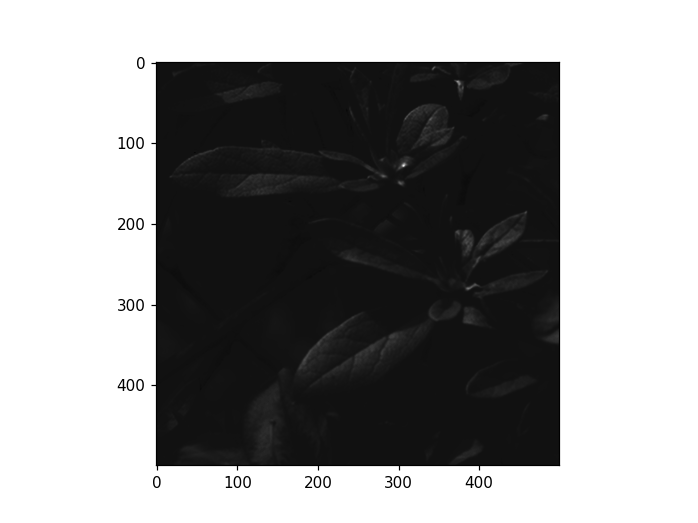

-3.68407
(2160, 3840)


In [26]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
print(np.mean(Y))

Y = -0.99+(Y-np.amin(Y))* 1.98/(np.amax(Y)-np.amin(Y))
plt.imshow(Y[h_top:h_top+500,w_top:w_top+500],cmap='gray')
print(Y.shape)
for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2
    print(np.amin(Y_lnl))

    plt.imshow(Y_lnl[h_top:h_top+500,w_top:w_top+500],cmap='gray')
    print(Y_lnl.shape)

<IPython.core.display.Javascript object>


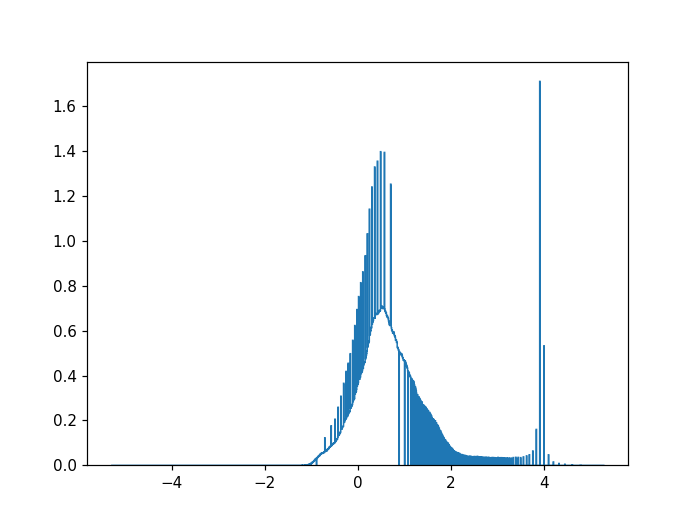

(2160, 3840)


<IPython.core.display.Javascript object>


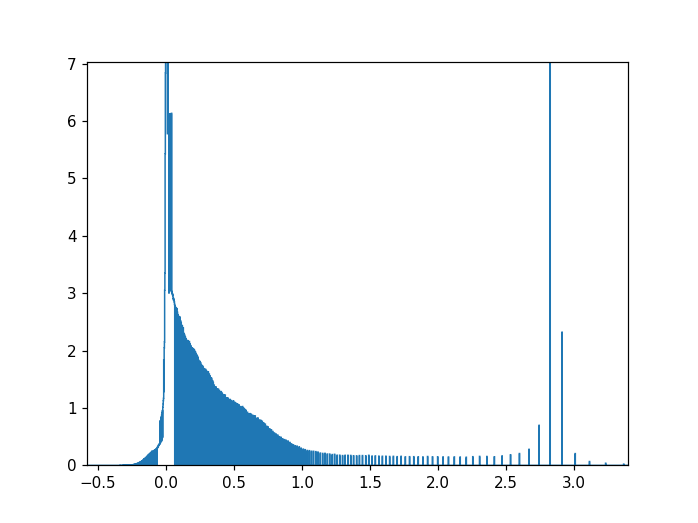

(2160, 3840)


<IPython.core.display.Javascript object>


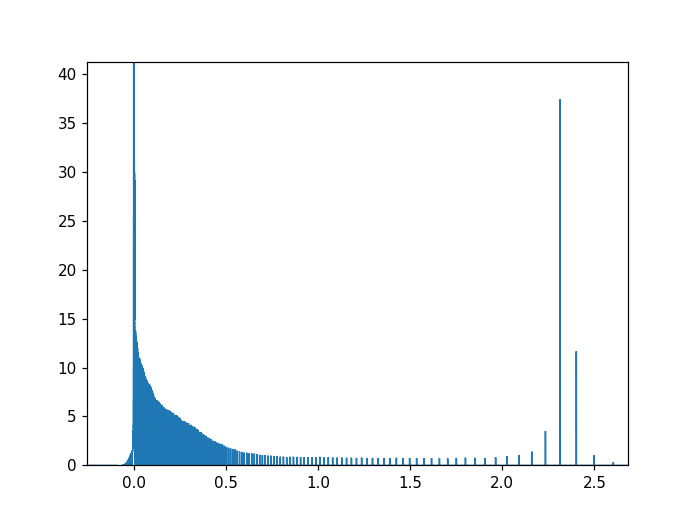

(2160, 3840)


In [35]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)


## Reference MSCN

<IPython.core.display.Javascript object>


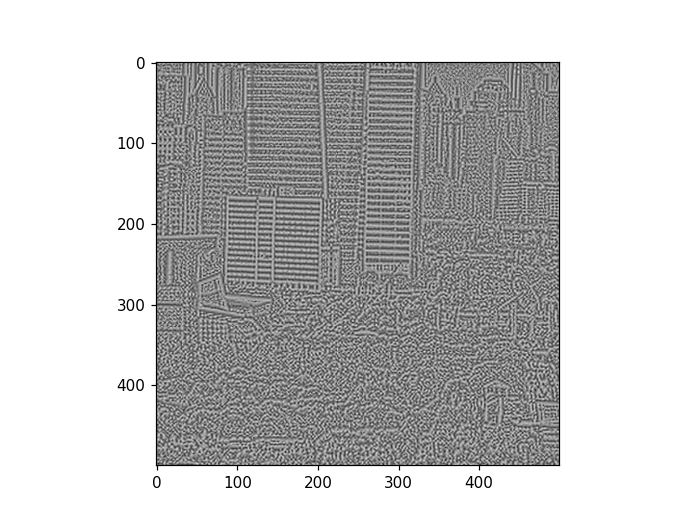

(2160, 3840)


<IPython.core.display.Javascript object>


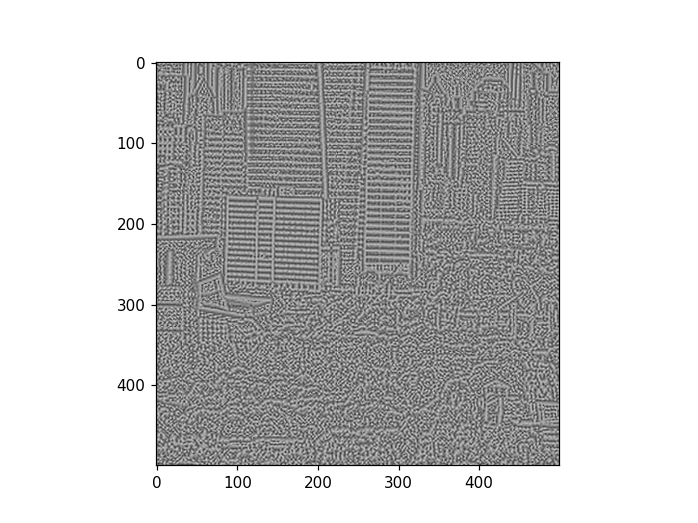

<IPython.core.display.Javascript object>


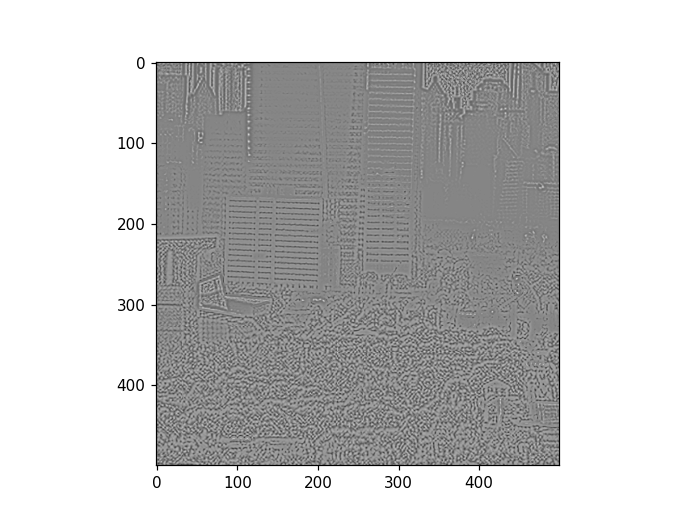

<IPython.core.display.Javascript object>


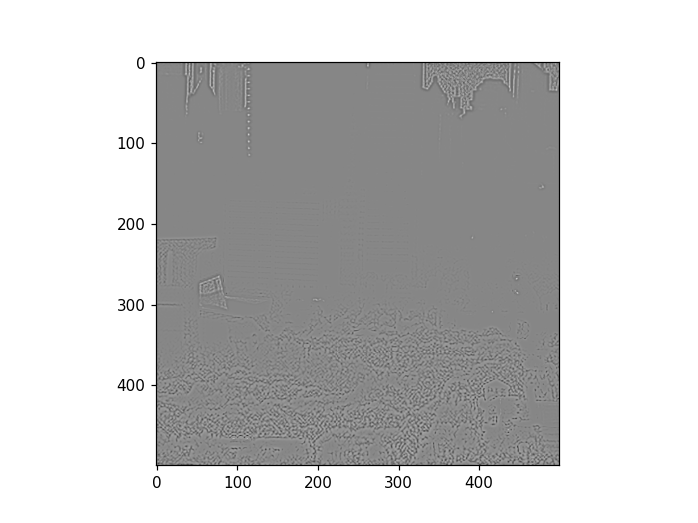

In [223]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn[h_top:h_top+500,w_top:w_top+500],cmap='gray')
print(Y_fcfs.shape)
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+500,w_top:w_top+500],cmap='gray')

## Distorted MSCN

<IPython.core.display.Javascript object>


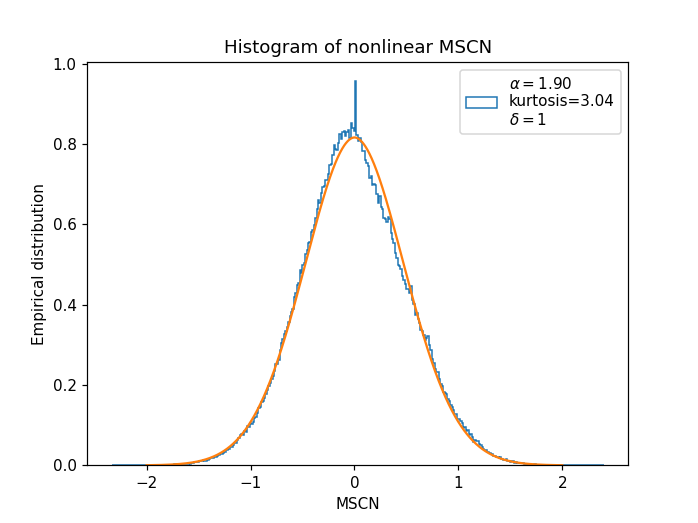

<IPython.core.display.Javascript object>


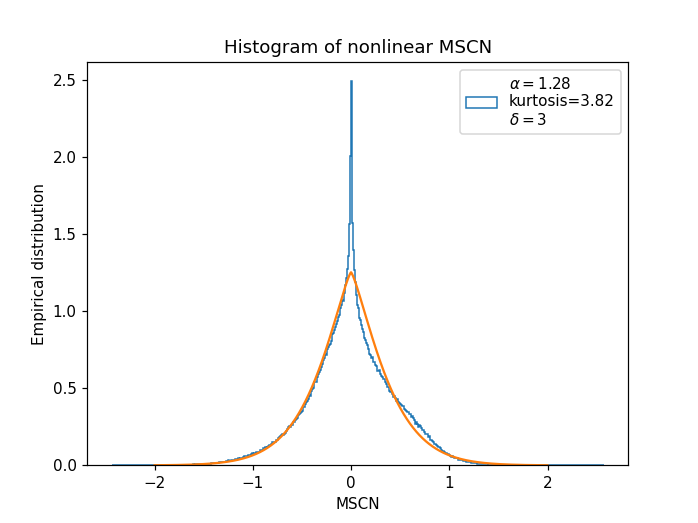

<IPython.core.display.Javascript object>


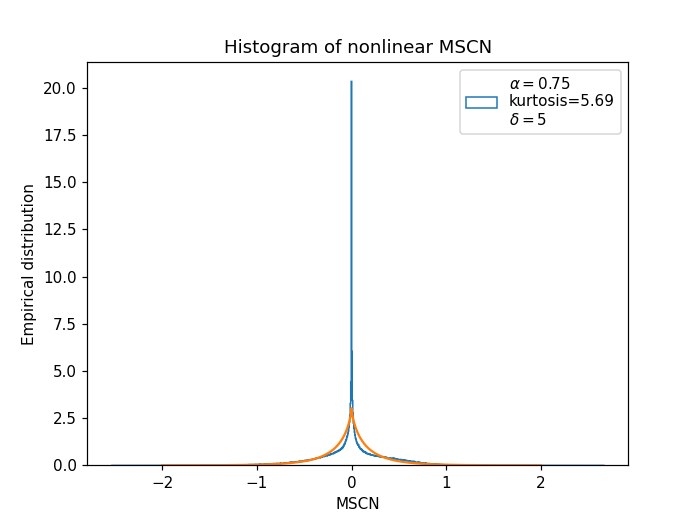

<IPython.core.display.Javascript object>


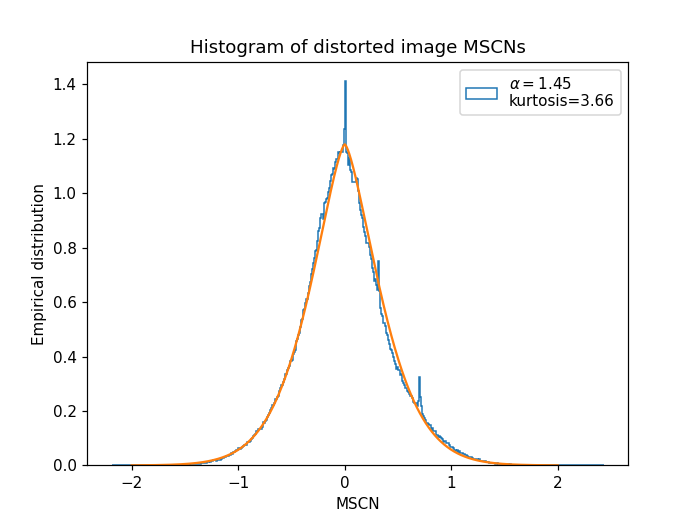

<IPython.core.display.Javascript object>


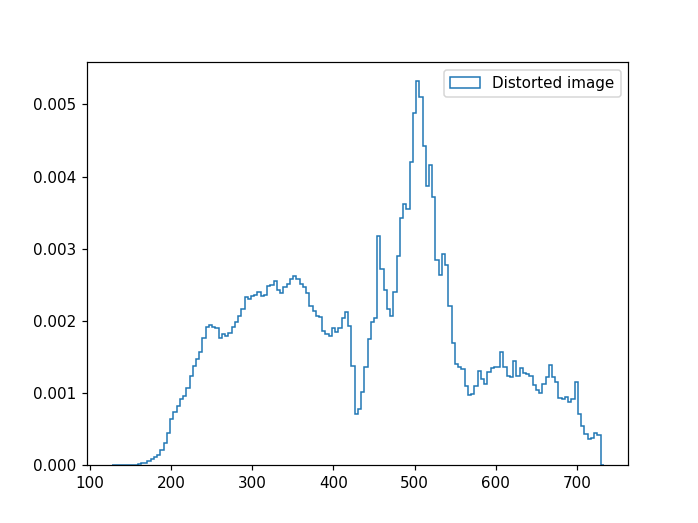

In [236]:


%matplotlib notebook
%matplotlib notebook

delta =[1,3,5]

for index,Y_lnl_mscn in enumerate(Y_lnl_mscn_list):
    Yplot = np.concatenate(Y_lnl_mscn).flatten()
    alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
    kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
    x = np.arange(-2,2,0.001)
    Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)
    Y_lnl = Y_lnl_list[index]
    

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)


    plt.figure()
    plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4]+'\n$\delta=$'+str(delta[index]),density=True)
    plt.plot(x,Y_ggd)
    plt.ylabel('Empirical distribution')
    plt.xlabel('MSCN')
    plt.title('Histogram of nonlinear MSCN')
    plt.legend()
    plt.show()
    

Yplot = np.concatenate(Y_mscn).flatten()
alpha,sigma = ChipQA.save_stats.estimateggdparam(Yplot-np.mean(Yplot))
kurt = kurtosis(Yplot-np.mean(Yplot),fisher=False)
x = np.arange(-2,2,0.001)
Y_ggd = ChipQA.save_stats.generate_ggd(x,alpha,sigma)

plt.figure()
plt.hist(Yplot-np.mean(Yplot),bins='auto',histtype='step',label=r'$\alpha=$'+str(alpha)[:4]+'\nkurtosis='+str(kurt)[:4],density=True)
plt.plot(x,Y_ggd)
plt.ylabel('Empirical distribution')
plt.xlabel('MSCN')
plt.title('Histogram of distorted image MSCNs')
plt.legend()
plt.show()
    
plt.figure()
plt.clf()
Yplot = Y.flatten()
plt.hist(Yplot,bins='auto',histtype='step',label=r'Distorted image',density=True)
plt.legend()




## Distorted LNL images

<IPython.core.display.Javascript object>


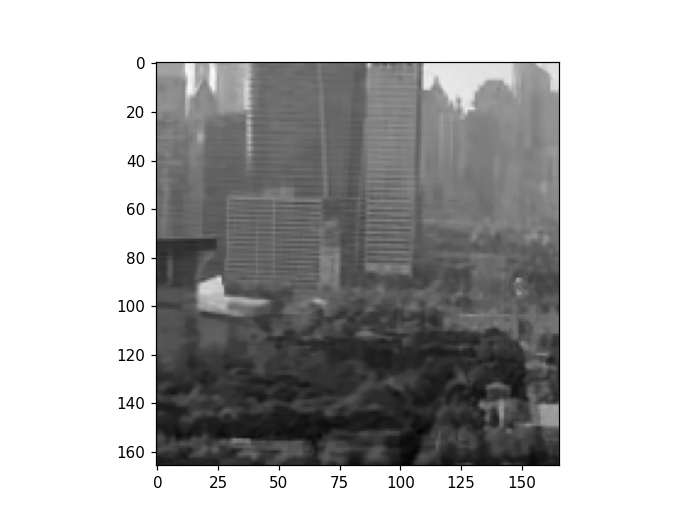

<IPython.core.display.Javascript object>


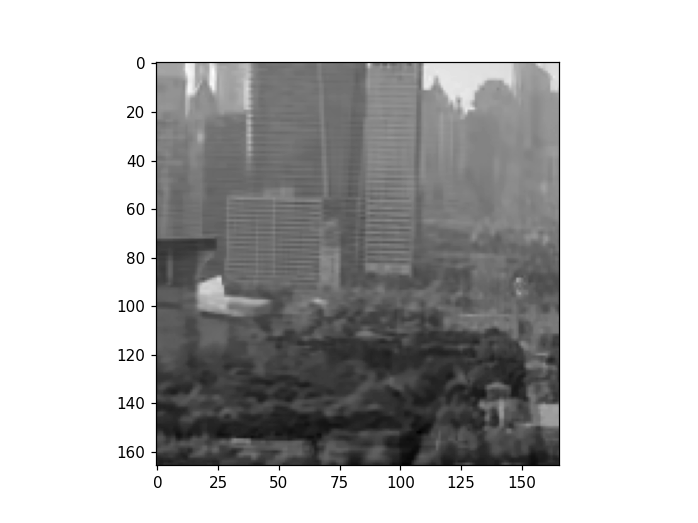

<IPython.core.display.Javascript object>


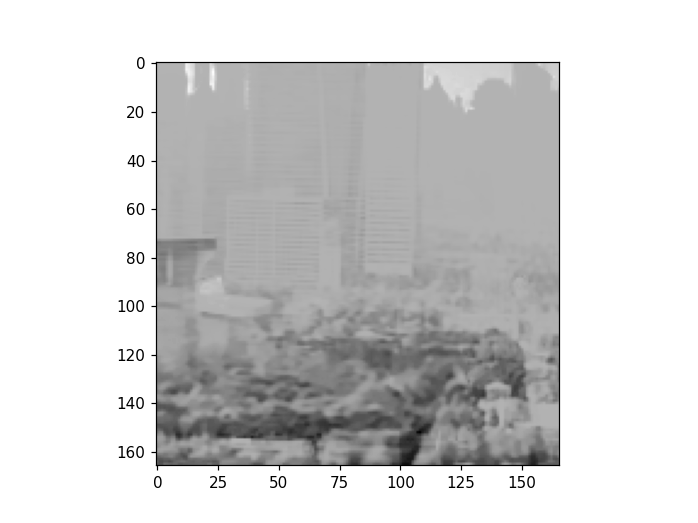

<IPython.core.display.Javascript object>


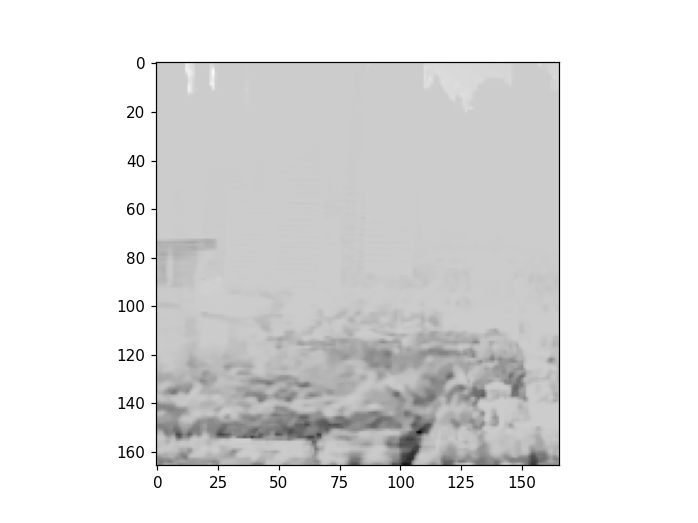

In [234]:
%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
plt.imshow(Y[h_top:h_top+166,w_top:w_top+166],cmap='gray')
# plt.imshow(Y,cmap='gray')
for Y_lnl in Y_lnl_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl-np.amin(Y_lnl))/(np.amax(Y_lnl)-np.amin(Y_lnl))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

<IPython.core.display.Javascript object>


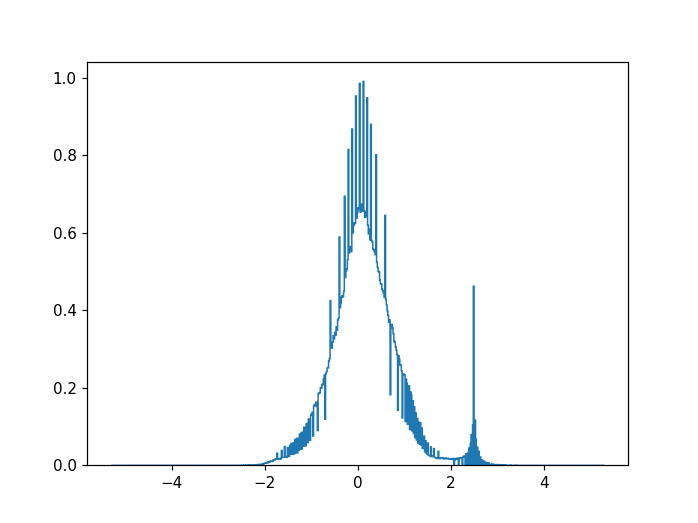

(720, 1280)


<IPython.core.display.Javascript object>


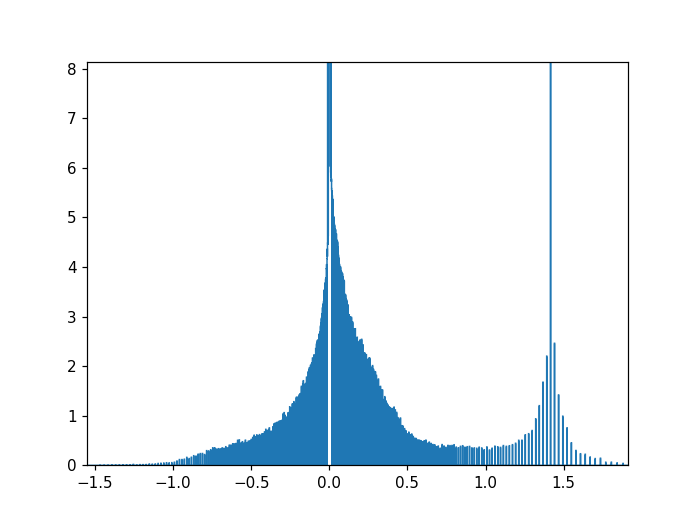

(720, 1280)


<IPython.core.display.Javascript object>


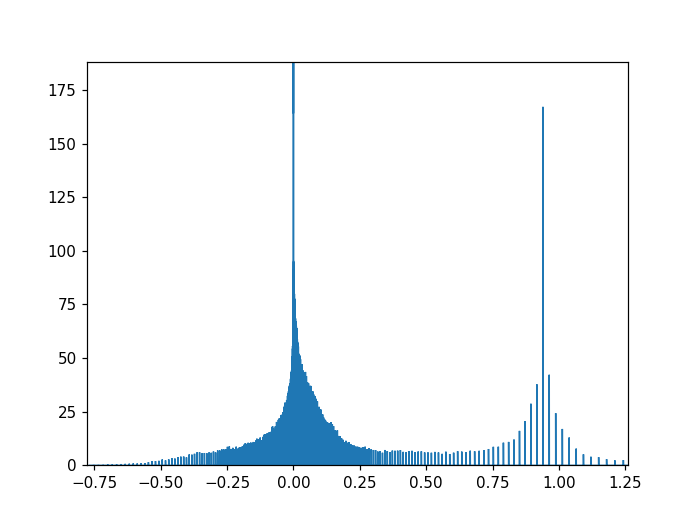

(720, 1280)


In [37]:
%matplotlib notebook
%matplotlib notebook



for Y_lnl in Y_lnl_list:
    Y_lnl = Y_lnl.astype(np.float32)

    plt.figure()
    plt.clf()
    Yplot = Y_lnl.flatten()
    plt.hist(Yplot,bins='auto',histtype='step',density=True)
    plt.show()

    print(Y_lnl.shape)

## Distorted MSCN images

<IPython.core.display.Javascript object>


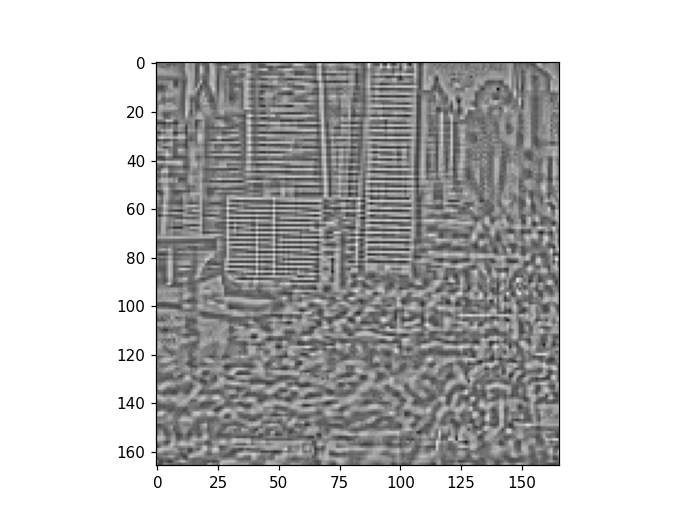

<IPython.core.display.Javascript object>


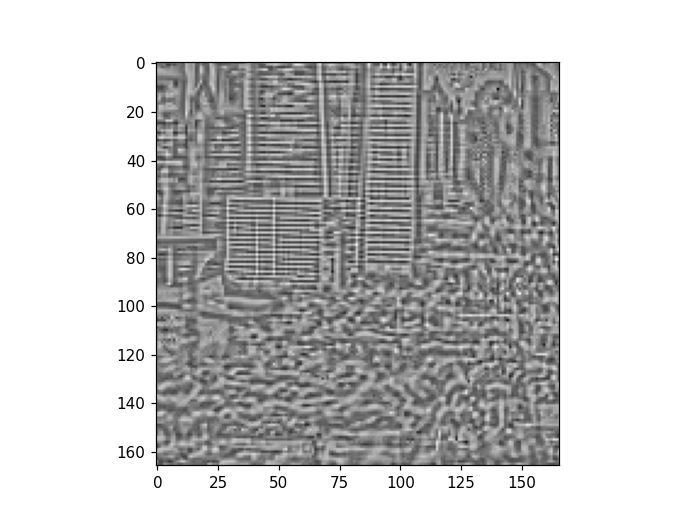

<IPython.core.display.Javascript object>


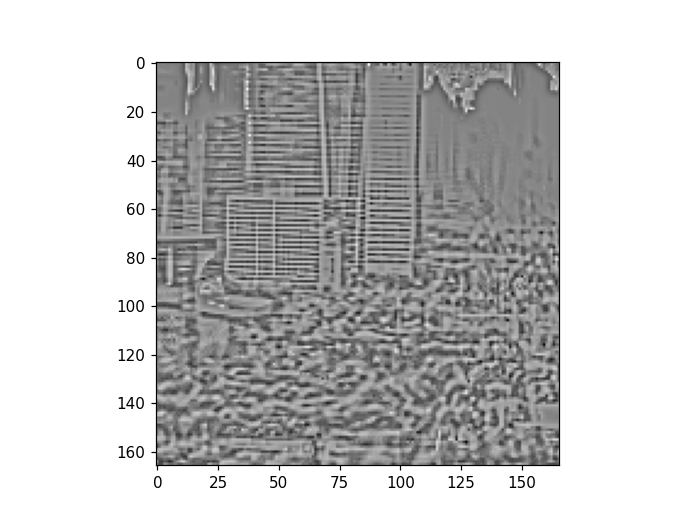

<IPython.core.display.Javascript object>


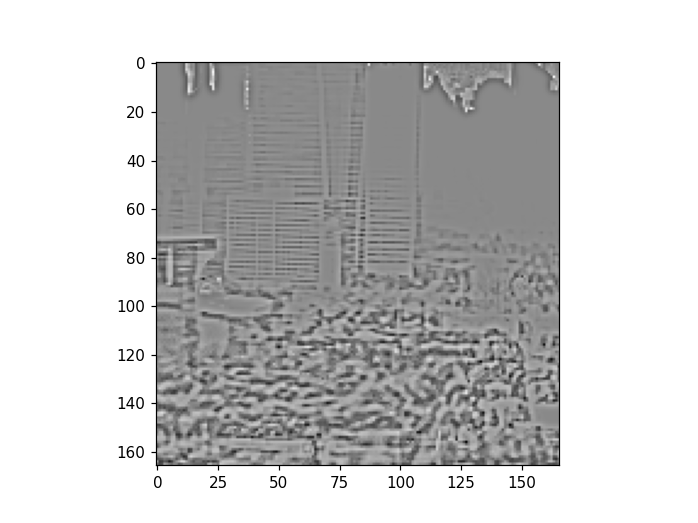

In [233]:
%matplotlib notebook
%matplotlib notebook

# plt.hist(np.concatenate(Y_lnl_mscn[0]).flatten(),bins='auto',histtype='step',density=True)
#plt.hist(np.concatenate(Y_lnl_mscn).flatten(),bins='auto',histtype='step',density=True)
# plt.hist(np.concatenate(Y_lnl_mscn[67]).flatten(),bins='auto',histtype='step',density=True)

%matplotlib notebook
%matplotlib notebook

plt.figure()
plt.clf()
Y_fcfs = (Y_mscn-np.amin(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn[h_top:h_top+166,w_top:w_top+166],cmap='gray')
for Y_lnl_mscn in Y_lnl_mscn_list:
    plt.figure()

    plt.clf()
    Y_fcfs = (Y_lnl_mscn-np.amin(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))
    
    h_top = Y_fcfs.shape[0]//2
    w_top = Y_fcfs.shape[1]//2

    plt.imshow(Y_fcfs[h_top:h_top+166,w_top:w_top+166],cmap='gray')

<IPython.core.display.Javascript object>


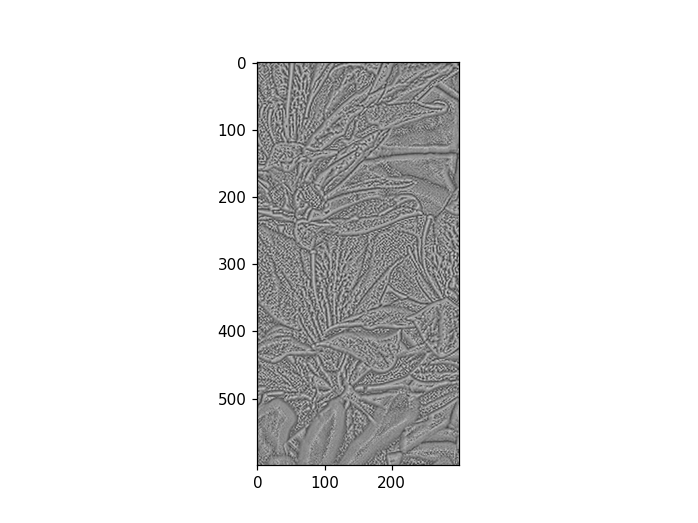

In [94]:
from matplotlib.colors import Normalize
plt.figure()
plt.clf()
Y_mscn_fcfs = (Y_mscn-np.min(Y_mscn))/(np.amax(Y_mscn)-np.amin(Y_mscn))
plt.imshow(Y_mscn_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

<IPython.core.display.Javascript object>


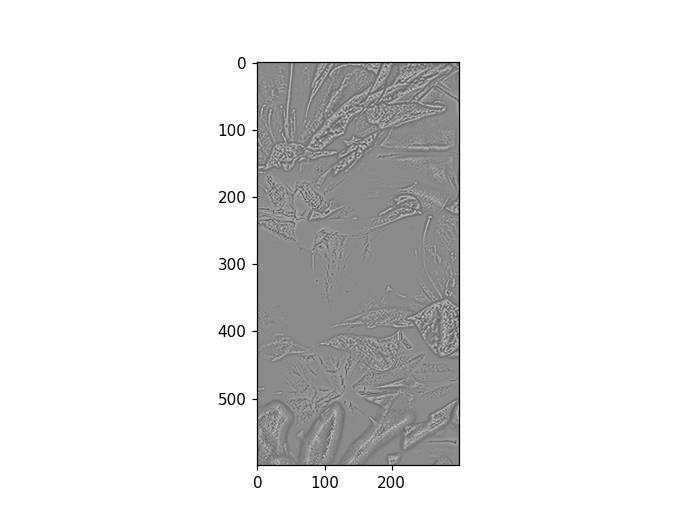

In [95]:
plt.figure()
plt.clf()
Y_lnl_mscn = Y_lnl_mscn_list[2]

plt.clf()
Y_fcfs = (Y_lnl_mscn-np.min(Y_lnl_mscn))/(np.amax(Y_lnl_mscn)-np.amin(Y_lnl_mscn))

plt.imshow(Y_fcfs[1400:2000,1000:1300],norm=Normalize(),cmap='gray')

In [ ]:
x = np.arange(0,1024)
y = x/(x+512)
plt.figure()
plt.clf()
plt.xlabel('L')
plt.ylabel('R')
plt.plot(x,y)

<IPython.core.display.Javascript object>


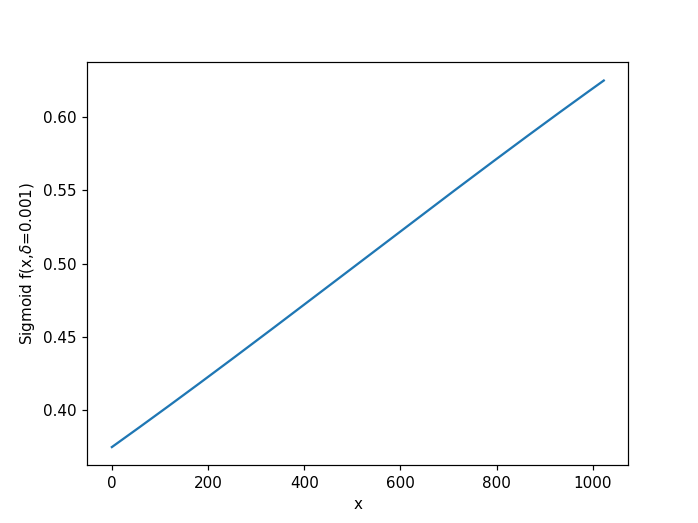

<IPython.core.display.Javascript object>


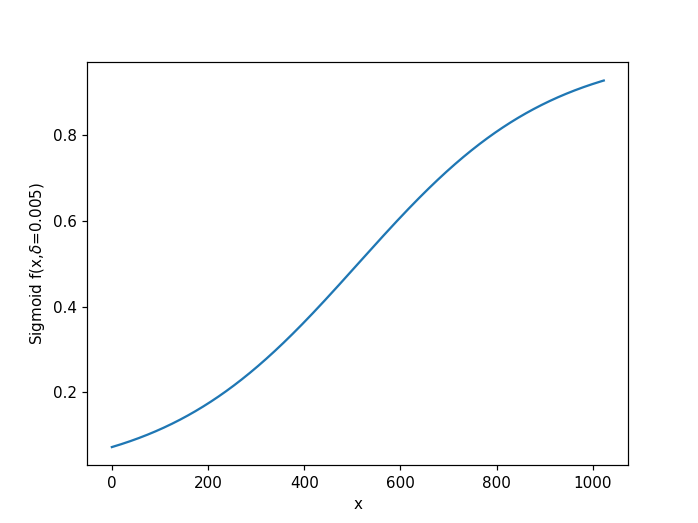

<IPython.core.display.Javascript object>


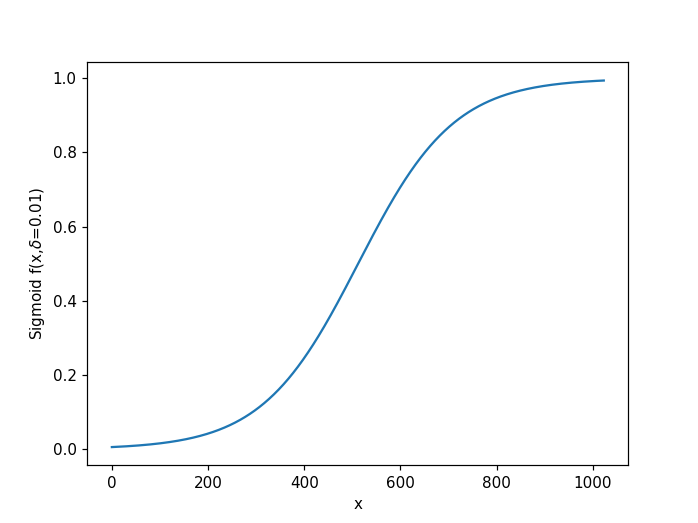

In [8]:
for delta in [0.001,0.005,0.01]:
    x = np.arange(0,1024)
    y = 1/(1+np.exp(-delta*(x-512)))
    plt.figure()
    plt.clf()
    plt.ylabel('Sigmoid f(x,$\delta$='+str(delta)+')')
    plt.xlabel('x')
    plt.plot(x,y)

<IPython.core.display.Javascript object>


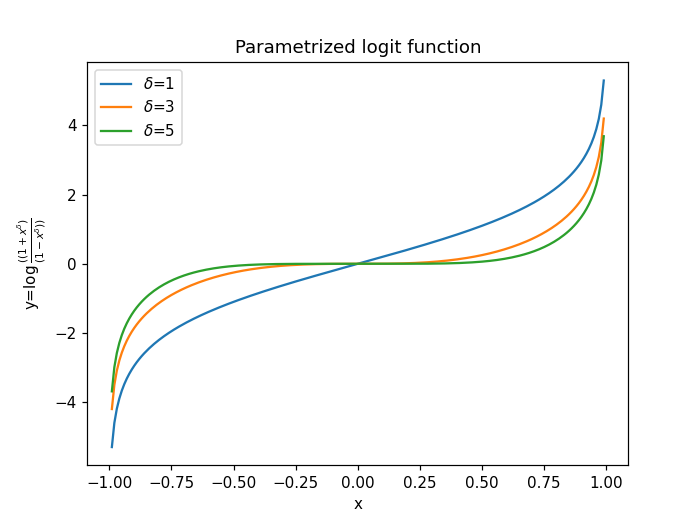

/tmp/ipykernel_204979/41904199.py:6: RuntimeWarning: divide by zero encountered in log
  y = np.log((1+x_d)/(1-x_d))
/tmp/ipykernel_204979/41904199.py:6: RuntimeWarning: divide by zero encountered in log
  y = np.log((1+x_d)/(1-x_d))
/tmp/ipykernel_204979/41904199.py:6: RuntimeWarning: divide by zero encountered in log
  y = np.log((1+x_d)/(1-x_d))


Text(0.5, 1.0, 'Parametrized logit function')

In [99]:
plt.figure()
plt.clf()
for delta in [1,3,5]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = np.log((1+x_d)/(1-x_d))
#     print(y)


    plt.plot(x,y,label='$\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$\log \\frac{((1+x^{\delta})}{(1-x^{\delta}))}$')
plt.xlabel('x')
plt.title('Parametrized logit function')

<IPython.core.display.Javascript object>


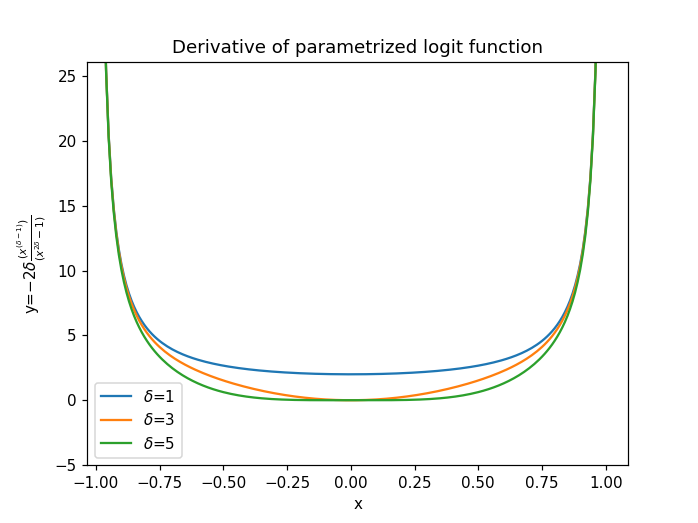

/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
/tmp/ipykernel_204979/2701842226.py:6: RuntimeWarning: divide by zero encountered in true_divide
  y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)


Text(0.5, 1.0, 'Derivative of parametrized logit function')

In [220]:
plt.figure()
plt.clf()
for delta in [1,3,5]:
    x = np.arange(-1,1,0.01)
    x_d = (x)**delta
    y = -2*delta*(x**(delta-1))/(x**(2*delta)-1)
#     print(y)


    plt.plot(x,y,label='$\delta$='+str(delta))
plt.legend()
plt.ylabel('y=$-2\delta \\frac{(x^{(\delta-1)})}{(x^{2\delta}-1)}$')
plt.xlabel('x')
plt.title('Derivative of parametrized logit function')